## XGBoost
从算法精度、速度和泛化能力等性能指标来看`GBDT`，仍然有较大的优化空间。`XGBoost`是一种基于`GBDT`的顶级梯度提升模型。相较于`GBDT`，`XGBoost`的最大特性在于对损失函数展开到二阶导数，使得梯度提升树模型更能逼近其真实损失。    
`XGBoost`全称`eXtreme Gradient Boosting`，即极限梯度提升树，由陈天奇在其论文`XGBoost:A Scalable Tree Boosting System`中提出。

### 1 XGBoost介绍

XGBoost本质上仍属于GBDT算法，但在`算法精度`、`速度`和`泛化能力`上均要优于传统的GBDT算法。从算法精度上来看，XGBoost通过`将损失函数展开到二阶导数`，使得其更能逼近真是损失；从算法速度上来看，XGBoost使用了`加权分位数sketch`和`稀疏感知算法`这两个技巧，通过`缓存优化`和`模型并行`来提高算法速度；从算法泛化能力上来看，通过`对损失函数加入正则化项`、加性模型中`设置缩减率`和`列抽样`等方法，来防止模型过拟合。

### 2 XGBoost算法实现
相较于GBDT，XGBoost的主要变化在于`损失函数二阶导数`、`信息增益计算`和`叶子结点得分计算`等方面，与上一章GBDT使用回归树不同，本章以分类树为例。   
整个实现过程概括为：从损失函数出发，进行二阶泰勒展开并重新定义一棵决策树，通过对叶子结点分组得到最终的损失函数形式，最后求得最优点和最优取值，并得到叶子结点的分裂标准。

In [2]:
from cart import BinaryDecisionTree
import numpy as np

# XGBoost单棵树类
class XGBoost_Single_Tree(BinaryDecisionTree):

    def node_split(self, y): # 结点分裂方法
        feature = int(np.shape(y)[1]/2) # 中间特征所在列
        y_true, y_pred = y[:, :feature], y[:, feature:] # 左子树为真实值，右子树为预测值
        return y_true, y_pred

    def gain(self, y, y_pred): # 信息增益计算方法
        Gradient = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2) # 梯度计算（一阶导数）
        Hessian = self.loss.hess(y, y_pred).sum() # 黑塞矩阵（二阶导数）
        return 0.5 * (Gradient / Hessian)

    def gain_xgb(self, y, y1, y2): # 树分裂增益计算-式（12-22）
        y_true, y_pred = self.node_split(y)
        y1, y1_pred = self.node_split(y1)
        y2, y2_pred = self.node_split(y2)
        true_gain = self.gain(y1, y1_pred)
        false_gain = self.gain(y2, y2_pred)
        gain = self.gain(y_true, y_pred)
        return true_gain + false_gain - gain

    def leaf_weight(self, y): # 计算叶子结点最优权重 w*
        y_true, y_pred = self.node_split(y)
        gradient = np.sum(y_true * self.loss.gradient(y_true, y_pred), axis=0) # 梯度计算
        hessian = np.sum(self.loss.hess(y_true, y_pred), axis=0) # 黑塞矩阵计算
        leaf_weight = gradient / hessian
        return leaf_weight

    # 树拟合方法
    def fit(self, X, y):
        # 信息增益和叶子节点得分计算都用到了损失函数二阶导数信息
        self.impurity_calculation = self.gain_xgb
        self._leaf_value_calculation = self.leaf_weight
        super(XGBoost_Single_Tree, self).fit(X, y)

In [23]:
# XGBoost分类损失函数
class Sigmoid: # 定义Sigmoid类
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))
    
    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

# 定义logit损失
class LogisticLoss:
    def __init__(self):
        sigmoid = Sigmoid()
        self._func = sigmoid
        self._grad = sigmoid.gradient
    
    # 定义Logit损失
    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1, 1e-15) # 截断函数
        p = self._func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)
    
    # 定义一阶梯度
    def gradient(self, y, y_pred):
        p = self._func(y_pred)
        return -(y - p)
    
    # 定义二阶梯度
    def hess(self, y, y_pred):
        p = self._func(y_pred)
        return p * (1 - p)

In [24]:
from utils import cat_label_convert

# XGBoost模型
class XGBoost:
    def __init__(self, n_estimators=300, learning_rate=0.001, min_samples_split=2, min_gini_impurity=999, max_depth=2):
        self.n_estimators = n_estimators # 树的棵数
        self.learning_rate = learning_rate # 学习率
        self.min_samples_split = min_samples_split # 结点分裂最小样本数
        self.min_gini_impurity = min_gini_impurity # 结点最小基尼不纯度
        self.max_depth = max_depth # 树最大深度
        self.loss = LogisticLoss() # 用于分类的对数损失，回归任务定义平方损失
        self.estimators = [] # 初始化分类树列表

        for _ in range(n_estimators): # 遍历构造每一棵决策树
            tree = XGBoost_Single_Tree(
                min_samples_split=self.min_samples_split,
                min_gini_impurity=self.min_gini_impurity,
                max_depth = max_depth,
                loss = self.loss
            )
            self.estimators.append(tree)

    def fit(self, X, y): # XGBoost拟合方法
        y = cat_label_convert(y) # one-hot
        y_pred = np.zeros(np.shape(y))
        for i in range(self.n_estimators): # 拟合每一棵树后将结果累加
            estimator = self.estimators[i]
            y_true_pred = np.concatenate((y, y_pred), axis=1)
            estimator.fit(X, y_true_pred)
            iter_pred = estimator.predict(X)
            y_pred -= np.multiply(self.learning_rate, iter_pred)

    def predict(self, X): # XGBoost预测方法
        y_pred = None
        for estimator in self.estimators: # 遍历预测
            iter_pred = estimator.predict(X)
            if y_pred is None:
                y_pred = np.zeros_like(iter_pred)
            y_pred -= np.multiply(self.learning_rate, iter_pred)
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [25]:
# XGBoost测试
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets # 导入鸢尾花数据集
data = datasets.load_iris()
X, y = data.data, data.target # 获取输入输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)  # 数据集划分
clf = XGBoost() # 创建xgboost分类器
clf.fit(X_train, y_train) # 模型拟合
y_pred = clf.predict(X_test) # 模型预测
accuracy = accuracy_score(y_test, y_pred) # 准确率评估
print ("Accuracy: ", accuracy)

e:\Jiawen9-s-Reading-Notes\机器学习公式推导与代码实现\chapter12-XGBoost\utils.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_left, X_right])


Accuracy:  0.9333333333333333


### 2 XGBoost原生库示例
XGBoost的作者陈天奇也提供了XGBoost原生的工业级官方库xgboost。   
首先需要指定xgboost模型训练的各种参数，包括提升树类型、任务类型、类别数量和树的最大深度等，然后将原始数据类型转换为xgboost的DMatrix数据类型，接着进行模型训练和预测，最后评估分类准确率，并绘制特征重要性图，可视化地呈现每个特征在模型中的重要性评分。

0.9666666666666667


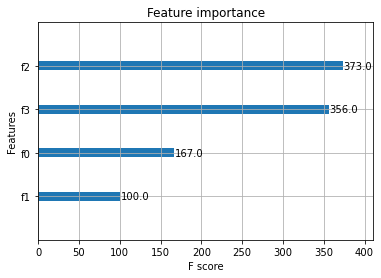

In [22]:
import xgboost as xgb
from xgboost import plot_importance # 导入绘制特征重要性模块函数
from matplotlib import pyplot as plt

# 设置模型参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 2,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.001,
    'seed': 1000,
    'nthread': 4,
}

dtrain = xgb.DMatrix(X_train, y_train) # 转换为xgb数据集格式Dmatrix
num_rounds = 200 # 树的棵数
model = xgb.train(params, dtrain, num_rounds)
y_pred = model.predict(xgb.DMatrix(X_test)) # 对测试集进行验证
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
plot_importance(model)
plt.show()